<a href="https://colab.research.google.com/github/MpRonald/Deep-Learning/blob/main/PyTorch_Autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
from torchvision import datasets, transforms
import torch
from torch import nn, optim
from torch.nn.modules.activation import Sigmoid
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [4]:
torch.manual_seed(42)

# Database

In [5]:
dataset_train = datasets.MNIST('MNIST-data', train=True, download=True, transform=transforms.ToTensor())
loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=256, shuffle=True)
dataset_val = datasets.MNIST('MNIST-data', train=False, download=True, transform=transforms.ToTensor())
loader_val = torch.utils.data.DataLoader(dataset_val, batch_size=256, shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting MNIST-data/MNIST/raw/train-images-idx3-ubyte.gz to MNIST-data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting MNIST-data/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST-data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting MNIST-data/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST-data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting MNIST-data/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST-data/MNIST/raw



In [6]:
class autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.dense0 = nn.Linear(in_features=784, out_features=32)
        self.activation0 = nn.ReLU()
        self.dense1 = nn.Linear(32,784)
        self.activation1 = nn.Sigmoid()

    def forward(self,X):
        X = X.view(-1, 28*28)
        X = self.dense0(X)
        X = self.activation0(X)
        X = self.dense1(X)
        X = self.activation1(X)

        return X

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [8]:
model = autoencoder()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters())

In [9]:
for epoch in range(10):
    #training
    r_loss = 0.
    for data in loader_train:
        model.train()
        inputs, _ = data
        inputs = inputs.to(device)
        optimizer.zero_grad()
        outputs = model.forward(inputs)
        loss = criterion(outputs, inputs.view(*outputs.shape))
        loss.backward()
        optimizer.step()
        r_loss += loss.item()

    # validation
    r_val = 0.
    for data in loader_val:
        model.eval()
        inputs, _ = data
        inputs = inputs.to(device)
        outputs = model.forward(inputs)
        loss = criterion(outputs, inputs.view(*outputs.shape))
        r_val += loss.item()

    print(f"Epoch: {epoch+1} --- Loss Train: {r_loss/len(loader_train)} --- Loss Eval: {r_val/len(loader_val)}")

Epoch: 1 --- Loss Train: 0.30737217525218397 --- Loss Eval: 0.2154150102287531
Epoch: 2 --- Loss Train: 0.19030869305133818 --- Loss Eval: 0.1689269933849573
Epoch: 3 --- Loss Train: 0.15796816298302183 --- Loss Eval: 0.14679054915905
Epoch: 4 --- Loss Train: 0.1427721641165145 --- Loss Eval: 0.1360139213502407
Epoch: 5 --- Loss Train: 0.13408545109819858 --- Loss Eval: 0.1294875280931592
Epoch: 6 --- Loss Train: 0.1268249958119494 --- Loss Eval: 0.12188855689018965
Epoch: 7 --- Loss Train: 0.12141105837010323 --- Loss Eval: 0.11803662404417992
Epoch: 8 --- Loss Train: 0.11824550111877158 --- Loss Eval: 0.11534593403339385
Epoch: 9 --- Loss Train: 0.11612822958763609 --- Loss Eval: 0.11336795743554831
Epoch: 10 --- Loss Train: 0.11467167341962774 --- Loss Eval: 0.11250857133418321


In [10]:
class encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.dense0 = list(model.children())[0]
        self.activation0 = list(model.children())[1]

    def forward(self, X):
        X = X.view(-1,28*28)
        X = self.dense0(X)
        X = self.activation0(X)
        return X

In [11]:
model2 = encoder()
model2.to(device)

encoder(
  (dense0): Linear(in_features=784, out_features=32, bias=True)
  (activation0): ReLU()
)

In [12]:
class decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.dense0 = list(model.children())[2]
        self.activation0 = list(model.children())[3]

    def forward(self, X):
        X = self.dense0(X)
        X = self.activation0(X)
        return X

In [13]:
model3 = decoder()
model3.to(device)

decoder(
  (dense0): Linear(in_features=32, out_features=784, bias=True)
  (activation0): Sigmoid()
)

In [14]:
image_num = 10
img_test = next(iter(loader_val))[0][:image_num]
img_test = img_test.to(device)

In [15]:
model2.eval()
img_cod = model2(img_test)
img_cod.shape

torch.Size([10, 32])

In [16]:
model3.eval()
img_decod = model3(img_cod)
img_decod.shape

torch.Size([10, 784])

In [17]:
img_test2 = img_test.detach().cpu().numpy().reshape(-1,28,28)
img_cod2 = img_cod.detach().cpu().numpy().reshape(-1,8,4)
img_decod2 = img_decod.detach().cpu().numpy().reshape(-1,28,28)

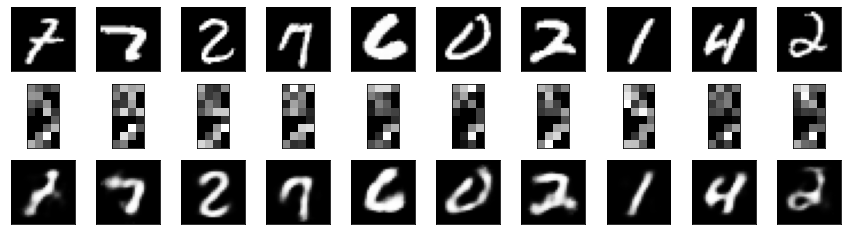

In [18]:
f, ax = plt.subplots(nrows=3, ncols=image_num, figsize=(15,4))
for images, ax_row in zip([img_test2, img_cod2, img_decod2], ax):
    for img, ax in zip(images, ax_row):
        ax.imshow(img, cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

## Codifying Predict

In [19]:
train_pred = (dataset_train.data.float() / 255).view(-1,784).to(device)
train_pred.shape

torch.Size([60000, 784])

In [20]:
with torch.no_grad():
    train_pred_cod = model2(train_pred)

In [21]:
train_class = dataset_train.targets

In [22]:
train_pred_cod.shape, train_class

(torch.Size([60000, 32]), tensor([5, 0, 4,  ..., 5, 6, 8]))

In [23]:
dataset_train_cod = torch.utils.data.TensorDataset(train_pred_cod, train_class)
loader_train_cod = torch.utils.data.DataLoader(dataset_train_cod, batch_size=256, shuffle=True)

In [24]:
val_pred = (dataset_val.data.float() / 255).view(-1,784).to(device)
with torch.no_grad():
    val_pred_cod = model2(val_pred)
val_class = dataset_val.targets
dataset_test_cod = torch.utils.data.TensorDataset(val_pred_cod, val_class)
loader_val_cod = torch.utils.data.DataLoader(dataset_test_cod, batch_size=256, shuffle=True)

# Classifier without Dimensionality Reduction

In [25]:
c1 = nn.Sequential(nn.Linear(784, 397),
                   nn.ReLU(),
                   nn.Linear(397, 10),
                   nn.LogSoftmax())
c1.to(device)
criterion = nn.NLLLoss()
optimizer = optim.Adam(c1.parameters())

In [26]:
for epoch in range(20):  
    # Treinamento
    running_loss_train = 0.
    running_accuracy_train = 0.
    for data in loader_train:
        c1.train()
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs.view(-1, 28*28)
        optimizer.zero_grad()
        outputs = c1(inputs)
        ps = torch.exp(outputs)
        _, top_class = ps.topk(k = 1, dim = 1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss_train += loss.item()
        running_accuracy_train += accuracy_score(labels.detach().cpu().numpy(), 
                                                 top_class.detach().cpu().numpy())
    
    # Validação
    running_loss_val = 0.
    running_accuracy_val = 0.
    for data in loader_val:
        c1.eval()
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs.view(-1, 28*28)
        outputs = c1(inputs)
        ps = torch.exp(outputs)
        _, top_class = ps.topk(k = 1, dim = 1)
        loss = criterion(outputs, labels)
        running_loss_val += loss.item()
        running_accuracy_val += accuracy_score(labels.detach().cpu().numpy(), 
                                               top_class.detach().cpu().numpy())
        
# Final da época
    
    print('Epoch {:3d}: | Train Loss {:.5f} | Train Precision {:5f} | Loss Val {:.5f} | Val Precision  {:5f}'.format(epoch + 1,
            running_loss_train/len(loader_train),
            running_accuracy_train/len(loader_train), 
            running_loss_val/len(loader_val),
            running_accuracy_val/len(loader_val)))
    print('-'*120)

Epoch   1: | Train Loss 0.41352 | Train Precision 0.891423 | Loss Val 0.21994 | Val Precision  0.938867
------------------------------------------------------------------------------------------------------------------------
Epoch   2: | Train Loss 0.18024 | Train Precision 0.948166 | Loss Val 0.14738 | Val Precision  0.957031
------------------------------------------------------------------------------------------------------------------------
Epoch   3: | Train Loss 0.12563 | Train Precision 0.963575 | Loss Val 0.10950 | Val Precision  0.966992
------------------------------------------------------------------------------------------------------------------------
Epoch   4: | Train Loss 0.09372 | Train Precision 0.972551 | Loss Val 0.09594 | Val Precision  0.970898
------------------------------------------------------------------------------------------------------------------------
Epoch   5: | Train Loss 0.07369 | Train Precision 0.979189 | Loss Val 0.08458 | Val Precision  0.974

## Etapa 8: Classificação com redução de dimensionalidade

In [27]:
c2 = nn.Sequential(
        nn.Linear(32, 21),
        nn.ReLU(),
        nn.Linear(21, 10),
        nn.LogSoftmax())
c2.to(device)
criterion = nn.NLLLoss()
optimizer = optim.Adam(c2.parameters())

In [28]:
for epoch in range(25): 
    running_loss_train = 0.
    running_accuracy_train = 0.
    for data in loader_train_cod:
        c2.train()
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = c2(inputs)
        ps = torch.exp(outputs)
        _, top_class = ps.topk(k = 1, dim = 1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss_train += loss.item()
        running_accuracy_train += accuracy_score(labels.detach().cpu().numpy(), 
                                                 top_class.detach().cpu().numpy())
    
    # Validação
    running_loss_val = 0.
    running_accuracy_val = 0.
    for data in loader_val_cod:
        c2.eval()
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = c2(inputs)
        ps = torch.exp(outputs)
        _, top_class = ps.topk(k = 1, dim = 1)
        loss = criterion(outputs, labels)
        running_loss_val += loss.item()
        running_accuracy_val += accuracy_score(labels.detach().cpu().numpy(), 
                                               top_class.detach().cpu().numpy())
        
    # Final da época
    print('Epoch {:3d}: | Train Loss {:.5f} | Train Precision {:5f} | Loss Val {:.5f} | Val Precision  {:5f}'.format(epoch + 1,
            running_loss_train/len(loader_train),
            running_accuracy_train/len(loader_train), 
            running_loss_val/len(loader_val),
            running_accuracy_val/len(loader_val)))
    print('-'*120)

Epoch   1: | Train Loss 1.53397 | Train Precision 0.541733 | Loss Val 0.73967 | Val Precision  0.803223
------------------------------------------------------------------------------------------------------------------------
Epoch   2: | Train Loss 0.57840 | Train Precision 0.841717 | Loss Val 0.47333 | Val Precision  0.870313
------------------------------------------------------------------------------------------------------------------------
Epoch   3: | Train Loss 0.44496 | Train Precision 0.872047 | Loss Val 0.41223 | Val Precision  0.878809
------------------------------------------------------------------------------------------------------------------------
Epoch   4: | Train Loss 0.40316 | Train Precision 0.881627 | Loss Val 0.36866 | Val Precision  0.892285
------------------------------------------------------------------------------------------------------------------------
Epoch   5: | Train Loss 0.38210 | Train Precision 0.886209 | Loss Val 0.35274 | Val Precision  0.897

#Images Zip with Deep Autoencoders

In [29]:
class autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        # encoder layer
        self.encoder0 = nn.Linear(in_features = 784, out_features = 128)
        self.encoder1 = nn.Linear(128, 64)
        self.encoder2 = nn.Linear(64, 32)
        
        # decoder layer
        self.decoder0 = nn.Linear(32, 64)
        self.decoder1 = nn.Linear(64, 128)
        self.decoder2 = nn.Linear(128, 784)
        
        # activation layer
        self.activation0 = nn.ReLU()
        self.activation1 = nn.Sigmoid()
    
    def forward(self, X):
        # encoder structure
        X = self.activation0(self.encoder0(X))
        X = self.activation0(self.encoder1(X))
        X = self.activation0(self.encoder2(X))
        
        # decoder structure
        X = self.activation0(self.decoder0(X))
        X = self.activation0(self.decoder1(X))
        X = self.activation1(self.decoder2(X))
        return X

In [30]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cpu')

In [31]:
model = autoencoder()
model.to(device)

autoencoder(
  (encoder0): Linear(in_features=784, out_features=128, bias=True)
  (encoder1): Linear(in_features=128, out_features=64, bias=True)
  (encoder2): Linear(in_features=64, out_features=32, bias=True)
  (decoder0): Linear(in_features=32, out_features=64, bias=True)
  (decoder1): Linear(in_features=64, out_features=128, bias=True)
  (decoder2): Linear(in_features=128, out_features=784, bias=True)
  (activation0): ReLU()
  (activation1): Sigmoid()
)

In [32]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters())

In [33]:
for epoch in range(20):
    running_loss_train = 0.
    for data in loader_train:
        model.train()
        inputs, _ = data 
        inputs = inputs.to(device)
        inputs = inputs.view(-1, 28*28)
        
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, inputs.view(*outputs.shape))
        loss.backward()
       
        optimizer.step()

        running_loss_train += loss.item()
    
    # validation
    running_loss_val = 0.
    for data in loader_val:
        model.eval()
        inputs, _ = data
        inputs = inputs.to(device)
        inputs = inputs.view(-1, 28*28)
        outputs = model(inputs)
        loss = criterion(outputs, inputs.view(*outputs.shape))
        running_loss_val += loss.item()

    
    print('Epoch{:3d}: Train Loss {:.5f} | Val Loss {:.5f}'.format(epoch + 1, running_loss_train/len(loader_train), running_loss_val/len(loader_val)))
    print('-'*80)

Epoch  1: Train Loss 0.29722 | Val Loss 0.24413
--------------------------------------------------------------------------------
Epoch  2: Train Loss 0.21184 | Val Loss 0.18065
--------------------------------------------------------------------------------
Epoch  3: Train Loss 0.16537 | Val Loss 0.15279
--------------------------------------------------------------------------------
Epoch  4: Train Loss 0.14806 | Val Loss 0.14291
--------------------------------------------------------------------------------
Epoch  5: Train Loss 0.14011 | Val Loss 0.13496
--------------------------------------------------------------------------------
Epoch  6: Train Loss 0.13262 | Val Loss 0.12712
--------------------------------------------------------------------------------
Epoch  7: Train Loss 0.12694 | Val Loss 0.12286
--------------------------------------------------------------------------------
Epoch  8: Train Loss 0.12335 | Val Loss 0.12039
-------------------------------------------------

In [34]:
class encoder2(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder0 = list(model.children())[0]
        self.encoder1 = list(model.children())[1]
        self.encoder2 = list(model.children())[2]      
        self.activation0 = list(model.children())[6]
    
    def forward(self, X):
        X = self.activation0(self.encoder0(X))
        X = self.activation0(self.encoder1(X))
        X = self.activation0(self.encoder2(X))     
        return X

In [35]:
model_e = encoder2()
model_e.to(device)

encoder2(
  (encoder0): Linear(in_features=784, out_features=128, bias=True)
  (encoder1): Linear(in_features=128, out_features=64, bias=True)
  (encoder2): Linear(in_features=64, out_features=32, bias=True)
  (activation0): ReLU()
)

In [36]:
class decoder2(nn.Module):
    def __init__(self):
        super().__init__()
        self.decoder0 = list(model.children())[3]
        self.decoder1 = list(model.children())[4]
        self.decoder2 = list(model.children())[5]        
        self.activation0 = list(model.children())[6]
        self.activation1 = list(model.children())[7]
    
    def forward(self, X):
        X = self.activation0(self.decoder0(X))
        X = self.activation0(self.decoder1(X))
        X = self.activation1(self.decoder2(X))       
        return X

In [37]:
model_e2 = decoder2()
model_e2.to(device)

decoder2(
  (decoder0): Linear(in_features=32, out_features=64, bias=True)
  (decoder1): Linear(in_features=64, out_features=128, bias=True)
  (decoder2): Linear(in_features=128, out_features=784, bias=True)
  (activation0): ReLU()
  (activation1): Sigmoid()
)

In [38]:
numero_imagens = 10

imagens_teste = next(iter(loader_val))[0][:numero_imagens]
imagens_teste = imagens_teste.to(device)
imagens_teste = imagens_teste.view(-1, 28*28)

In [39]:
imagens_teste.shape

torch.Size([10, 784])

In [40]:
# Imagens codificadas 
model_e.eval()
imagens_codificadas = model_e(imagens_teste)

In [41]:
imagens_codificadas.shape

torch.Size([10, 32])

In [42]:
# Imagens decodificadas
model_e2.eval()
imagens_decodificadas = model_e2(imagens_codificadas)

In [43]:
imagens_decodificadas.shape

torch.Size([10, 784])

In [44]:
# Formatando as imagens para visualização
imagens_teste = imagens_teste.detach().cpu().numpy().reshape(-1, 28, 28)
imagens_codificadas = imagens_codificadas.detach().cpu().numpy().reshape(-1,8,4)
imagens_decodificadas = imagens_decodificadas.detach().cpu().numpy().reshape(-1,28,28)

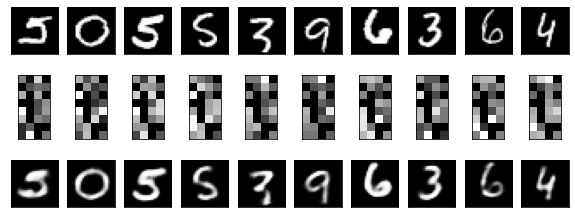

In [45]:
fig, axes = plt.subplots(nrows = 3, ncols = numero_imagens, figsize = (10, 4))
for imagens, ax_row in zip([imagens_teste, imagens_codificadas, 
                            imagens_decodificadas], axes):
    for img, ax in zip(imagens, ax_row):
        ax.imshow(img, cmap = 'gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)